In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
auth = pd.read_csv("../input/benfakenews/Authentic-48K.csv")
fake = pd.read_csv("../input/benfakenews/Fake-1K.csv")

In [3]:
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from tqdm.notebook import tqdm
from transformers import BertModel, BertTokenizer, BertForSequenceClassification

In [4]:
!pip install bnltk
!pip install bnlp-toolkit==4.0.0.dev4

  Preparing metadata (setup.py) ... done
  Created wheel for sklearn: filename=sklearn-0.0.post10-py3-none-any.whl size=2959 sha256=4854b95090411e2bff0d8f7575ecf4fce47b3f6b15d996c468e09b22f9a2ee58
  Stored in directory: /root/.cache/pip/wheels/5b/f6/92/0173054cc528db7ffe7b0c7652a96c3102aab156a6da960387
Successfully built sklearn
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 kB 7.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.5/993.5 kB 26.4 MB/s eta 0:00:00
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171033 sha256=d6afca2bdcf625eee2725c05ad1597ce52067f32b3cf924f933d6b354fbe40bb
  Stored in directory: /root/.cache/pip/wheels/31/8a/8c/315c9e5d7773f74b33d5ed33f075b49c6eaeb7cedbb86e2cf8
Successfully built emoji
  Attempting uninstall: emoji
    Found existing installation: emoji 2.8.0
    Uninstalling emoji-2.8.0:


In [5]:
df = pd.concat([auth[:fake.shape[0]*7], fake])
df = df.sample(frac=1).reset_index(drop=True)
len(df)

10392

In [6]:
df = df.drop('domain', axis=1)
df = df.drop('date', axis=1)
df = df.drop('category', axis=1)
df = df.drop('articleID', axis=1)

In [7]:
df['data'] = df['headline'] + ' ' + df['content']

In [8]:
df['class'] = df['label'].replace({0: 'fake', 1: 'true'})

In [9]:
df = df.drop('headline', axis=1)
df = df.drop('content', axis=1)
df = df.drop('label', axis=1)




In [10]:
df["class"].value_counts()

class
true    9093
fake    1299
Name: count, dtype: int64

In [11]:
df.dropna(inplace=True)
df["class"].value_counts()

class
true    9093
fake    1299
Name: count, dtype: int64

In [12]:
for column in df.columns:
    df[column] = df[column].str.slice(0, 100)

In [13]:
df

,data,class
0,যুক্তফ্রন্টের সমাবেশে যাবে বিএনপি! ‘যুক্তফ্রন্...,true
1,বেনাপোলে পিস্তল-গুলিসহ চোরাকারবারি গ্রেপ্তার ব...,true
2,ইসলামকে বিশ্বের সবচেয়ে শান্তির ধর্ম ঘোষণা ইউনে...,fake
3,সামাজিক যোগাযোগ মাধ্যমেও জমে উঠবে নির্বাচনের ল...,true
4,নির্বাচনকালীন সরকারে মন্ত্রী থাকবো: এরশাদ ফাইল...,true
...,...,...
10387,"আসগর, রশিদ ও হাসানকে জরিমানা করলো আইসিসি খেলা ...",true
10388,আমরা হতবাক | দৈনিক মতিকণ্ঠ মতিচুর রহমানবিশিষ্ঠ...,fake
10389,‘গাঙচিল’র মহরতে চার মন্ত্রী সড়ক পরিবহন ও সেতুম...,true
10390,এইচএসসির ফলাফল ১৯জুলাই! পাশের হার ৪৮%! এইচএসসি...,fake


In [14]:
df["class"].value_counts()

class
true    9093
fake    1299
Name: count, dtype: int64

In [15]:
df_lengths = df.applymap(lambda x: len(str(x)))

# Display the DataFrame with string lengths
print(df_lengths)

       data  class
0       100      4
1       100      4
2       100      4
3       100      4
4       100      4
...     ...    ...
10387   100      4
10388   100      4
10389   100      4
10390   100      4
10391   100      4

[10392 rows x 2 columns]


In [16]:
#Tokenizer
from bnlp import NLTKTokenizer
bnltk = NLTKTokenizer()

#for Train Set
for i in range(0,df.shape[0]):
    text = bnltk.word_tokenize(df['data'][i])
    df['data'][i] = str(text)

In [17]:
df

,data,class
0,"['যুক্তফ্রন্টের', 'সমাবেশে', 'যাবে', 'বিএনপি',...",true
1,"['বেনাপোলে', 'পিস্তল-গুলিসহ', 'চোরাকারবারি', '...",true
2,"['ইসলামকে', 'বিশ্বের', 'সবচেয়ে', 'শান্তির', 'ধ...",fake
3,"['সামাজিক', 'যোগাযোগ', 'মাধ্যমেও', 'জমে', 'উঠব...",true
4,"['নির্বাচনকালীন', 'সরকারে', 'মন্ত্রী', 'থাকবো'...",true
...,...,...
10387,"['আসগর', ',', 'রশিদ', 'ও', 'হাসানকে', 'জরিমানা...",true
10388,"['আমরা', 'হতবাক', '|', 'দৈনিক', 'মতিকণ্ঠ', 'মত...",fake
10389,"['‘', 'গাঙচিল', '’', 'র', 'মহরতে', 'চার', 'মন্...",true
10390,"['এইচএসসির', 'ফলাফল', '১৯জুলাই', '!', 'পাশের',...",fake


In [18]:
from bnlp import BengaliCorpus as corpus

stop_words = set(corpus.stopwords)


for i in range(0,df.shape[0]):
    words = df['data'][i]
    df['data'][i] =  str([word for word in words if word.lower() not in stop_words])


In [19]:
df

,data,class
0,"['[', ""'"", 'য', 'ু', 'ক', '্', 'ত', 'ফ', '্', ...",true
1,"['[', ""'"", 'ব', 'ে', 'ন', 'া', 'প', 'ো', 'ল', ...",true
2,"['[', ""'"", 'স', 'ল', 'া', 'ম', 'ক', 'ে', ""'"", ...",fake
3,"['[', ""'"", 'স', 'া', 'ম', 'া', 'জ', 'ি', 'ক', ...",true
4,"['[', ""'"", 'ন', 'ি', '্', 'ব', 'া', 'চ', 'ন', ...",true
...,...,...
10387,"['[', ""'"", 'আ', 'স', 'গ', ""'"", ',', ' ', ""'"", ...",true
10388,"['[', ""'"", 'আ', 'ম', 'া', ""'"", ',', ' ', ""'"", ...",fake
10389,"['[', ""'"", '‘', ""'"", ',', ' ', ""'"", 'গ', 'া', ...",true
10390,"['[', ""'"", 'চ', 'স', 'স', 'ি', ""'"", ',', ' ', ...",fake


In [20]:
text = df['data'].values.tolist()
label = df['class'].tolist()

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(text , label, test_size=0.2, random_state=42)

In [22]:
pip install ktrain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.3/25.3 MB 43.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 51.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 653.6/653.6 kB 40.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.4/199.4 kB 17.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.8/468.8 kB 34.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for ktrain: filename=ktrain-0.38.0-py3-none-any.whl size=25319964 sha256=72de8b337a

In [23]:

import ktrain
from ktrain import text
MODEL_NAME = 'xlm-roberta-base'
t = text.Transformer(MODEL_NAME, maxlen=500)

In [24]:
trn = t.preprocess_train(X_train, y_train)
val = t.preprocess_test(X_test, y_test)

preprocessing train...
language: bn
train sequence lengths:
	mean : 156
	95percentile : 176
	99percentile : 186


Is Multi-Label? False
preprocessing test...
language: bn
test sequence lengths:
	mean : 156
	95percentile : 176
	99percentile : 184


In [25]:
model = t.get_classifier()

In [26]:
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=6)


In [27]:
history = learner.fit_onecycle(2e-5, 10)




begin training using onecycle policy with max lr of 2e-05...
Epoch 1/10
1386/1386 [==============================] - 732s 513ms/step - loss: 0.3740 - accuracy: 0.8736 - val_loss: 0.3650 - val_accuracy: 0.8797
Epoch 2/10
1386/1386 [==============================] - 706s 509ms/step - loss: 0.3168 - accuracy: 0.8876 - val_loss: 0.2863 - val_accuracy: 0.9192
Epoch 3/10
1386/1386 [==============================] - 706s 509ms/step - loss: 0.3000 - accuracy: 0.9124 - val_loss: 0.2448 - val_accuracy: 0.9211
Epoch 4/10
1386/1386 [==============================] - 706s 509ms/step - loss: 0.3417 - accuracy: 0.8911 - val_loss: 0.3699 - val_accuracy: 0.8797
Epoch 5/10
1386/1386 [==============================] - 707s 510ms/step - loss: 0.3853 - accuracy: 0.8738 - val_loss: 0.3750 - val_accuracy: 0.8797
Epoch 6/10
1386/1386 [==============================] - 707s 510ms/step - loss: 0.3816 - accuracy: 0.8738 - val_loss: 0.3681 - val_accuracy: 0.8797
Epoch 7/10
1386/1386 [===========================

In [28]:
learner.validate(class_names=t.get_classes()) 


65/65 [==============================] - 46s 666ms/step
              precision    recall  f1-score   support

        fake       0.00      0.00      0.00       250
        true       0.88      1.00      0.94      1829

    accuracy                           0.88      2079
   macro avg       0.44      0.50      0.47      2079
weighted avg       0.77      0.88      0.82      2079



array([[   0,  250],
       [   0, 1829]])

In [29]:
def PlotGraph(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'g', label='Training acc')
    plt.plot(x, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'g', label='Training loss')
    plt.plot(x, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend() 

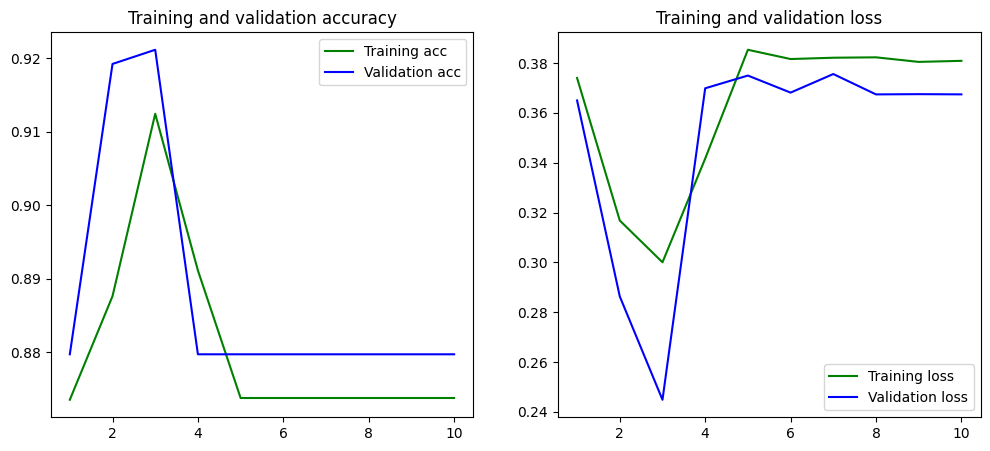

In [30]:
PlotGraph(history)